In [1]:
! pip install neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:

In [73]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from neuralop.data.datasets import DarcyDataset, load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.losses.data_losses import LpLoss
from neuralop.training import Trainer

device = 'cpu'

In [11]:
import matplotlib.pyplot as plt

def visualize_pair(x_all, y_all, idx):
    """
    Plot x_all[idx] and y_all[idx] side by side.

    Parameters
    ----------
    x_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    y_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    idx   : int, which sample to plot

    Displays a matplotlib figure.
    """
    # if torch.Tensor, convert to numpy
    if hasattr(x_all, 'cpu'):
        x = x_all[idx].cpu().numpy()
    else:
        x = x_all[idx]
    if hasattr(y_all, 'cpu'):
        y = y_all[idx].cpu().numpy()
    else:
        y = y_all[idx]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x, aspect='equal')
    axes[0].set_title(f'x_all[{idx}]')
    axes[0].axis('off')

    axes[1].imshow(y, aspect='equal')
    axes[1].set_title(f'y_all[{idx}]')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Load Darcy Flow Dataset

In [22]:
ds = DarcyDataset(root_dir="./data", n_train= 5000, n_tests= [1000, 500],
                 batch_size = 32, test_batch_sizes = [32, 32],
                 train_resolution= 16,
                 test_resolutions =[16,32],download=True)

Loading test db for resolution 16 with 1000 samples 
Loading test db for resolution 32 with 500 samples 


In [23]:
a = ds.train_db
full_loader = DataLoader(a,
                         batch_size=len(a),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
# batch is a dict, so:
x_all = batch['x']        # shape [1000, 1, 16, 16]
y_all = batch['y']
x_all = x_all.squeeze(1)  # → [1000, 16, 16]
y_all = y_all.squeeze(1)
print(x_all.shape)        # should print: torch.Size([1000, 16, 16])
print(y_all.shape)        # should print: torch.Size([1000, 16, 16])

torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])


In [24]:
b = ds.test_dbs[16]
full_loader = DataLoader(b,
                         batch_size=len(b),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
x_all_test = batch['x']
y_all_test = batch['y']
x_all_test = x_all_test.squeeze(1)
y_all_test = y_all_test.squeeze(1)
print(x_all_test.shape)        # should print: torch.Size([1000, 16, 16])
print(y_all_test.shape)        # should print: torch.Size([1000, 16, 16])

torch.Size([50, 16, 16])
torch.Size([50, 16, 16])


In [ ]:
# Wrap x/y tensors in a dict-style dataset
class DictDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.unsqueeze(1)  # [B, 1, H, W]
        self.y = y.unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = DictDataset(x_all, y_all)

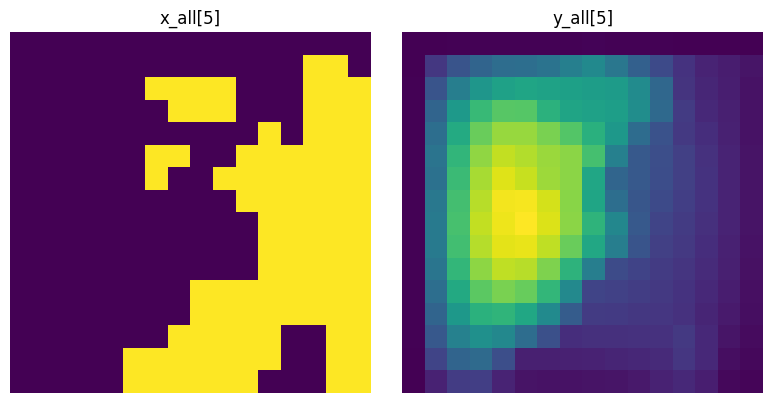

In [25]:
visualize_pair(x_all_test, y_all_test, idx=5)

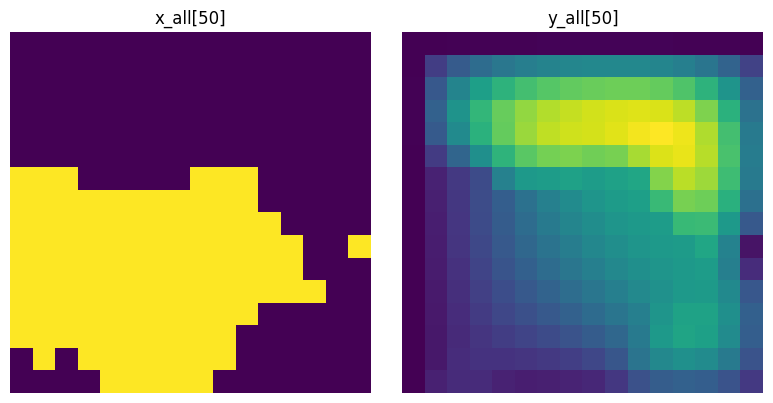

In [26]:
visualize_pair(x_all, y_all, idx=50)

# Define FNO Model

In [61]:
model = FNO(
    n_modes=(12, 12),         # Fourier modes per spatial dimension
    hidden_channels=32,       # Width of hidden layers
    in_channels=1,            # Darcy x shape: [B, 1, H, W]
    out_channels=1,           # Darcy y shape: [B, 1, H, W]
    num_layers=4,             # Number of Fourier layers
    use_mlp=True              # MLP head after FNO core
)

print(f"Model has {count_model_params(model)} parameters.")

Model has 701281 parameters.


In [67]:
# Training loop
def train_fno_model(model,
                    dataset,
                    num_epochs=100,
                    batch_size=32,
                    lr=1e-3,
                    val_split=0.1,
                    device="cuda" if torch.cuda.is_available() else "cpu"):
    # Split dataset
    N = len(dataset)
    n_val = int(N * val_split)
    n_train = N - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float('inf')
    best_state = None

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
        for i, (x, y) in enumerate(train_bar):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=f"{train_loss / (i + 1):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        avg_val = val_loss / max(len(val_loader), 1)

        print(f"Epoch {epoch:3d} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {avg_val:.6f}")

        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
            print(f" → New best model (Val Loss = {best_val:.6f})")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model.to("cpu")

In [68]:
best_model = train_fno_model(
    model,
    dataset,
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    val_split=0.1
)

Epoch   1 | Train Loss: 0.158766 | Val Loss: 0.115880
 → New best model (Val Loss = 0.115880)


Epoch   2 | Train Loss: 0.083428 | Val Loss: 0.044677
 → New best model (Val Loss = 0.044677)


Epoch   3 | Train Loss: 0.027464 | Val Loss: 0.023527
 → New best model (Val Loss = 0.023527)


Epoch   4 | Train Loss: 0.020824 | Val Loss: 0.020205
 → New best model (Val Loss = 0.020205)


Epoch   5 | Train Loss: 0.018213 | Val Loss: 0.018387
 → New best model (Val Loss = 0.018387)


Epoch   6 | Train Loss: 0.015712 | Val Loss: 0.014233
 → New best model (Val Loss = 0.014233)


Epoch   7 | Train Loss: 0.012294 | Val Loss: 0.011794
 → New best model (Val Loss = 0.011794)


Epoch   8 | Train Loss: 0.010989 | Val Loss: 0.011204
 → New best model (Val Loss = 0.011204)


Epoch   9 | Train Loss: 0.009188 | Val Loss: 0.008884
 → New best model (Val Loss = 0.008884)


Epoch  10 | Train Loss: 0.007971 | Val Loss: 0.008253
 → New best model (Val Loss = 0.008253)


Epoch  11 | Train Loss: 0.006792 | Val Loss: 0.007198
 → New best model (Val Loss = 0.007198)


Epoch  12 | Train Loss: 0.006057 | Val Loss: 0.006622
 → New best model (Val Loss = 0.006622)


Epoch  13 | Train Loss: 0.005752 | Val Loss: 0.007015


Epoch  14 | Train Loss: 0.005220 | Val Loss: 0.006008
 → New best model (Val Loss = 0.006008)


Epoch  15 | Train Loss: 0.004854 | Val Loss: 0.005702
 → New best model (Val Loss = 0.005702)


Epoch  16 | Train Loss: 0.004238 | Val Loss: 0.005791


Epoch  17 | Train Loss: 0.004075 | Val Loss: 0.005445
 → New best model (Val Loss = 0.005445)


Epoch  18 | Train Loss: 0.003630 | Val Loss: 0.005116
 → New best model (Val Loss = 0.005116)


Epoch  19 | Train Loss: 0.003461 | Val Loss: 0.004859
 → New best model (Val Loss = 0.004859)


Epoch  20 | Train Loss: 0.003312 | Val Loss: 0.004996


Epoch  21 | Train Loss: 0.003395 | Val Loss: 0.004750
 → New best model (Val Loss = 0.004750)


Epoch  22 | Train Loss: 0.002977 | Val Loss: 0.004675
 → New best model (Val Loss = 0.004675)


Epoch  23 | Train Loss: 0.002553 | Val Loss: 0.004451
 → New best model (Val Loss = 0.004451)


Epoch  24 | Train Loss: 0.002479 | Val Loss: 0.004380
 → New best model (Val Loss = 0.004380)


Epoch  25 | Train Loss: 0.002280 | Val Loss: 0.004380
 → New best model (Val Loss = 0.004380)


Epoch  26 | Train Loss: 0.002165 | Val Loss: 0.004270
 → New best model (Val Loss = 0.004270)


Epoch  27 | Train Loss: 0.001989 | Val Loss: 0.004240
 → New best model (Val Loss = 0.004240)


Epoch  28 | Train Loss: 0.001992 | Val Loss: 0.004117
 → New best model (Val Loss = 0.004117)


Epoch  29 | Train Loss: 0.001954 | Val Loss: 0.004013
 → New best model (Val Loss = 0.004013)


Epoch  30 | Train Loss: 0.001828 | Val Loss: 0.003977
 → New best model (Val Loss = 0.003977)


Epoch  31 | Train Loss: 0.001747 | Val Loss: 0.003896
 → New best model (Val Loss = 0.003896)


Epoch  32 | Train Loss: 0.001657 | Val Loss: 0.003925


Epoch  33 | Train Loss: 0.001667 | Val Loss: 0.004068


Epoch  34 | Train Loss: 0.001541 | Val Loss: 0.003752
 → New best model (Val Loss = 0.003752)


Epoch  35 | Train Loss: 0.001551 | Val Loss: 0.004059


Epoch  36 | Train Loss: 0.001516 | Val Loss: 0.003757


Epoch  37 | Train Loss: 0.001442 | Val Loss: 0.003764


Epoch  38 | Train Loss: 0.001338 | Val Loss: 0.003774


Epoch  39 | Train Loss: 0.001372 | Val Loss: 0.003700
 → New best model (Val Loss = 0.003700)


Epoch  40 | Train Loss: 0.001268 | Val Loss: 0.003715


Epoch  41 | Train Loss: 0.001244 | Val Loss: 0.003624
 → New best model (Val Loss = 0.003624)


Epoch  42 | Train Loss: 0.001196 | Val Loss: 0.003670


Epoch  43 | Train Loss: 0.001157 | Val Loss: 0.003639


Epoch  44 | Train Loss: 0.001148 | Val Loss: 0.003872


Epoch  45 | Train Loss: 0.001113 | Val Loss: 0.003608
 → New best model (Val Loss = 0.003608)


Epoch  46 | Train Loss: 0.001093 | Val Loss: 0.003770


Epoch  47 | Train Loss: 0.001113 | Val Loss: 0.003616


Epoch  48 | Train Loss: 0.001183 | Val Loss: 0.003536
 → New best model (Val Loss = 0.003536)


Epoch  49 | Train Loss: 0.001070 | Val Loss: 0.003579


Epoch  50 | Train Loss: 0.001019 | Val Loss: 0.003498
 → New best model (Val Loss = 0.003498)


Epoch  51 | Train Loss: 0.000982 | Val Loss: 0.003756


Epoch  52 | Train Loss: 0.000973 | Val Loss: 0.003495
 → New best model (Val Loss = 0.003495)


Epoch  53 | Train Loss: 0.000972 | Val Loss: 0.003535


Epoch  54 | Train Loss: 0.000987 | Val Loss: 0.003579


Epoch  55 | Train Loss: 0.000901 | Val Loss: 0.003510


Epoch  56 | Train Loss: 0.000971 | Val Loss: 0.003431
 → New best model (Val Loss = 0.003431)


Epoch  57 | Train Loss: 0.000914 | Val Loss: 0.003481


Epoch  58 | Train Loss: 0.000890 | Val Loss: 0.003497


Epoch  59 | Train Loss: 0.000870 | Val Loss: 0.003446


Epoch  60 | Train Loss: 0.000828 | Val Loss: 0.003393
 → New best model (Val Loss = 0.003393)


Epoch  61 | Train Loss: 0.000850 | Val Loss: 0.003491


Epoch  62 | Train Loss: 0.000824 | Val Loss: 0.003588


Epoch  63 | Train Loss: 0.000856 | Val Loss: 0.003451


Epoch  64 | Train Loss: 0.000813 | Val Loss: 0.003454


Epoch  65 | Train Loss: 0.000797 | Val Loss: 0.003413


Epoch  66 | Train Loss: 0.000781 | Val Loss: 0.003409


Epoch  67 | Train Loss: 0.000760 | Val Loss: 0.003329
 → New best model (Val Loss = 0.003329)


Epoch  68 | Train Loss: 0.000748 | Val Loss: 0.003455


Epoch  69 | Train Loss: 0.000730 | Val Loss: 0.003502


Epoch  70 | Train Loss: 0.000752 | Val Loss: 0.003367


Epoch  71 | Train Loss: 0.000716 | Val Loss: 0.003374


Epoch  72 | Train Loss: 0.000707 | Val Loss: 0.003481


Epoch  73 | Train Loss: 0.000692 | Val Loss: 0.003384


Epoch  74 | Train Loss: 0.000675 | Val Loss: 0.003372


Epoch  75 | Train Loss: 0.000661 | Val Loss: 0.003425


Epoch  76 | Train Loss: 0.000656 | Val Loss: 0.003430


Epoch  77 | Train Loss: 0.000652 | Val Loss: 0.003292
 → New best model (Val Loss = 0.003292)


Epoch  78 | Train Loss: 0.000644 | Val Loss: 0.003408


Epoch  79 | Train Loss: 0.000654 | Val Loss: 0.003545


Epoch  80 | Train Loss: 0.000656 | Val Loss: 0.003659


Epoch  81 | Train Loss: 0.000666 | Val Loss: 0.003617


Epoch  82 | Train Loss: 0.000642 | Val Loss: 0.003418


Epoch  83 | Train Loss: 0.000649 | Val Loss: 0.003446


Epoch  84 | Train Loss: 0.000632 | Val Loss: 0.003455


Epoch  85 | Train Loss: 0.000599 | Val Loss: 0.003310


Epoch  86 | Train Loss: 0.000594 | Val Loss: 0.003312


Epoch  87 | Train Loss: 0.000578 | Val Loss: 0.003452


Epoch  88 | Train Loss: 0.000587 | Val Loss: 0.003431


Epoch  89 | Train Loss: 0.000590 | Val Loss: 0.003327


Epoch  90 | Train Loss: 0.000572 | Val Loss: 0.003367


Epoch  91 | Train Loss: 0.000559 | Val Loss: 0.003316


Epoch  92 | Train Loss: 0.000535 | Val Loss: 0.003380


Epoch  93 | Train Loss: 0.000528 | Val Loss: 0.003239
 → New best model (Val Loss = 0.003239)


Epoch  94 | Train Loss: 0.000537 | Val Loss: 0.003348


Epoch  95 | Train Loss: 0.000533 | Val Loss: 0.003311


Epoch  96 | Train Loss: 0.000617 | Val Loss: 0.003514


Epoch  97 | Train Loss: 0.000665 | Val Loss: 0.003368


Epoch  98 | Train Loss: 0.000597 | Val Loss: 0.003431


Epoch  99 | Train Loss: 0.000523 | Val Loss: 0.003324


Epoch 100 | Train Loss: 0.000500 | Val Loss: 0.003383


# Plot Results

In [71]:
def run_and_plot(x_raw, y_raw, model, title, device="cpu"):
    """
    x_raw, y_raw: torch.Tensor shape [16,16]
    model: CPU model that maps x → y directly in spatial domain
    """
    # 1) Add batch and channel dimensions
    x = x_raw.unsqueeze(0).unsqueeze(0).to(device)  # [1,1,16,16]
    y = y_raw.unsqueeze(0).unsqueeze(0).to(device)  # [1,1,16,16]

    # 2) Run model
    model.eval()
    with torch.no_grad():
        y_pred = model(x)  # shape: [1,1,16,16]

    # 3) Remove batch and channel dims
    x = x.squeeze().cpu()       # [16,16]
    y = y.squeeze().cpu()       # [16,16]
    y_pred = y_pred.squeeze().cpu()  # [16,16]

    # 4) Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.numpy(), cmap='viridis'); axs[0].set_title(f"{title}: input x")
    axs[1].imshow(y.numpy(), cmap='viridis'); axs[1].set_title(f"{title}: true y")
    axs[2].imshow(y_pred.numpy(), cmap='viridis'); axs[2].set_title(f"{title}: predicted y")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

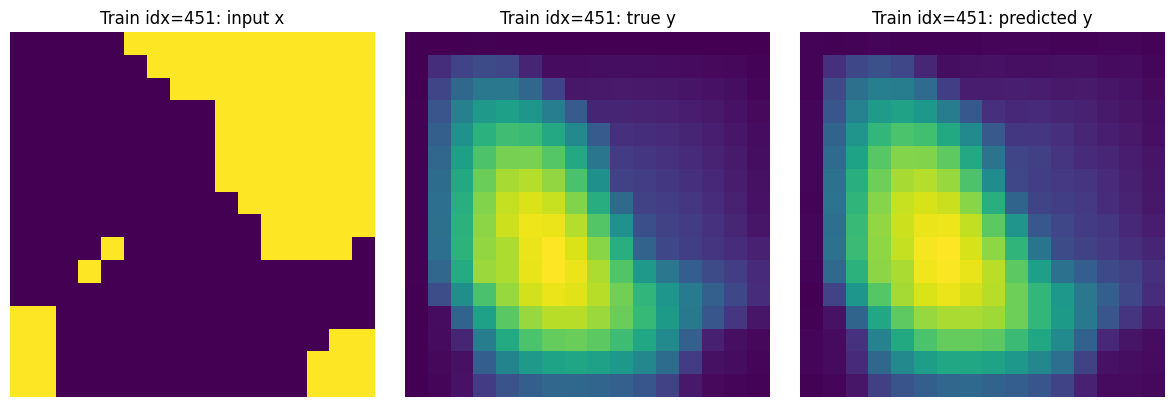

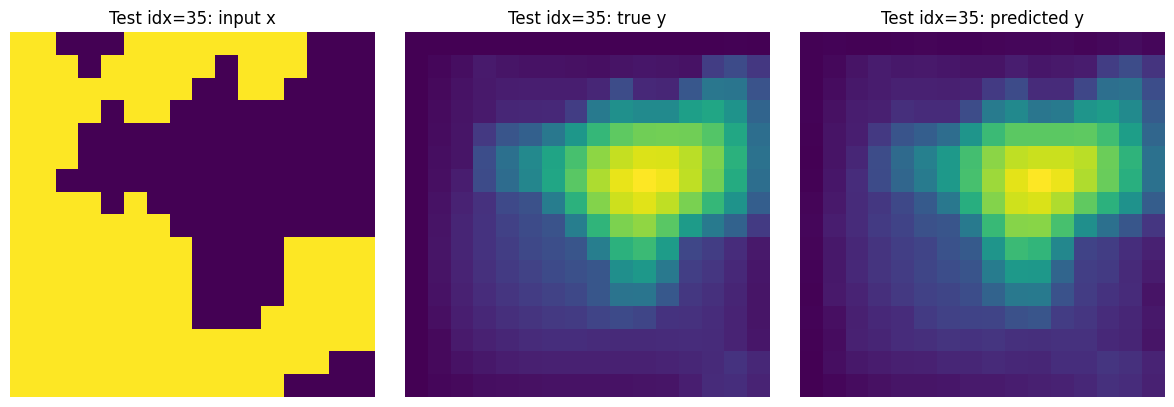

In [78]:
# Pick random train index
idx_train = random.randrange(x_all.shape[0])
run_and_plot(x_all[idx_train], y_all[idx_train], best_model, f"Train idx={idx_train}")

# Pick random test index
idx_test = random.randrange(x_all_test.shape[0])
run_and_plot(x_all_test[idx_test], y_all_test[idx_test], best_model, f"Test idx={idx_test}")